# Outlier detection using Isolation Forest
Created by Ivan Lima on Wed Oct 13 2021 08:59:21 -0400

In this notebook we test using Isolation Forest to detect outliers in the bottle data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Jul 25 16:54:01 2023


In [2]:
# sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
import sns_settings
sns.set_context('paper')
pd.options.display.max_columns = 50

## Read data

In [3]:
# # read merged bottle/satellite data
# df = pd.read_csv('data/bottle_satellite_data.csv', parse_dates=['Date'], index_col=0)
# df['bottom_depth'] = df.bottom_depth.abs() # convert negative to positive values
# # flag anomalous O2 values
# df['outlier'] = 0 # outlier flag
# df.loc[df.Oxygen>500, 'outlier'] = 1
# df.loc[(df.Oxygen>300) & (df.Depth>200), 'outlier'] = 1
# df = df[df.outlier==0]

# read Louise's bottle data
df = pd.read_csv('data/bottle_data_20210219.csv', parse_dates={'Date':['Year','Month','Day']}, index_col=1)
df = df[df.Oxygen>0] # filter negative (missing) values
df = df[df.Depth>0]  # filter negative (missing) values
df = df[df.Depth<600]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3479 entries, 1 to 9987
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3479 non-null   datetime64[ns]
 1   X.1              3479 non-null   int64         
 2   X                3479 non-null   int64         
 3   DOI              3479 non-null   object        
 4   EXPOCODE         2084 non-null   object        
 5   Accession        28 non-null     float64       
 6   Cruise_ID        2665 non-null   object        
 7   Time_UTC         3373 non-null   object        
 8   Latitude         3479 non-null   float64       
 9   Longitude        3479 non-null   float64       
 10  Depth_bottom     2153 non-null   float64       
 11  Depth            3479 non-null   float64       
 12  CASTNO_Original  3442 non-null   object        
 13  CASTNO_Database  3479 non-null   int64         
 14  Pressure         2529 non-null   float64

## Detect outliers 

Here we apply Isolation Forest to the input variables: depth, temperature, salinity, dissolved oxygen, DIC and total alkalinity.

1044 outliers out of 3479 data points (30.0%)
Cleaned data set: 2435 points


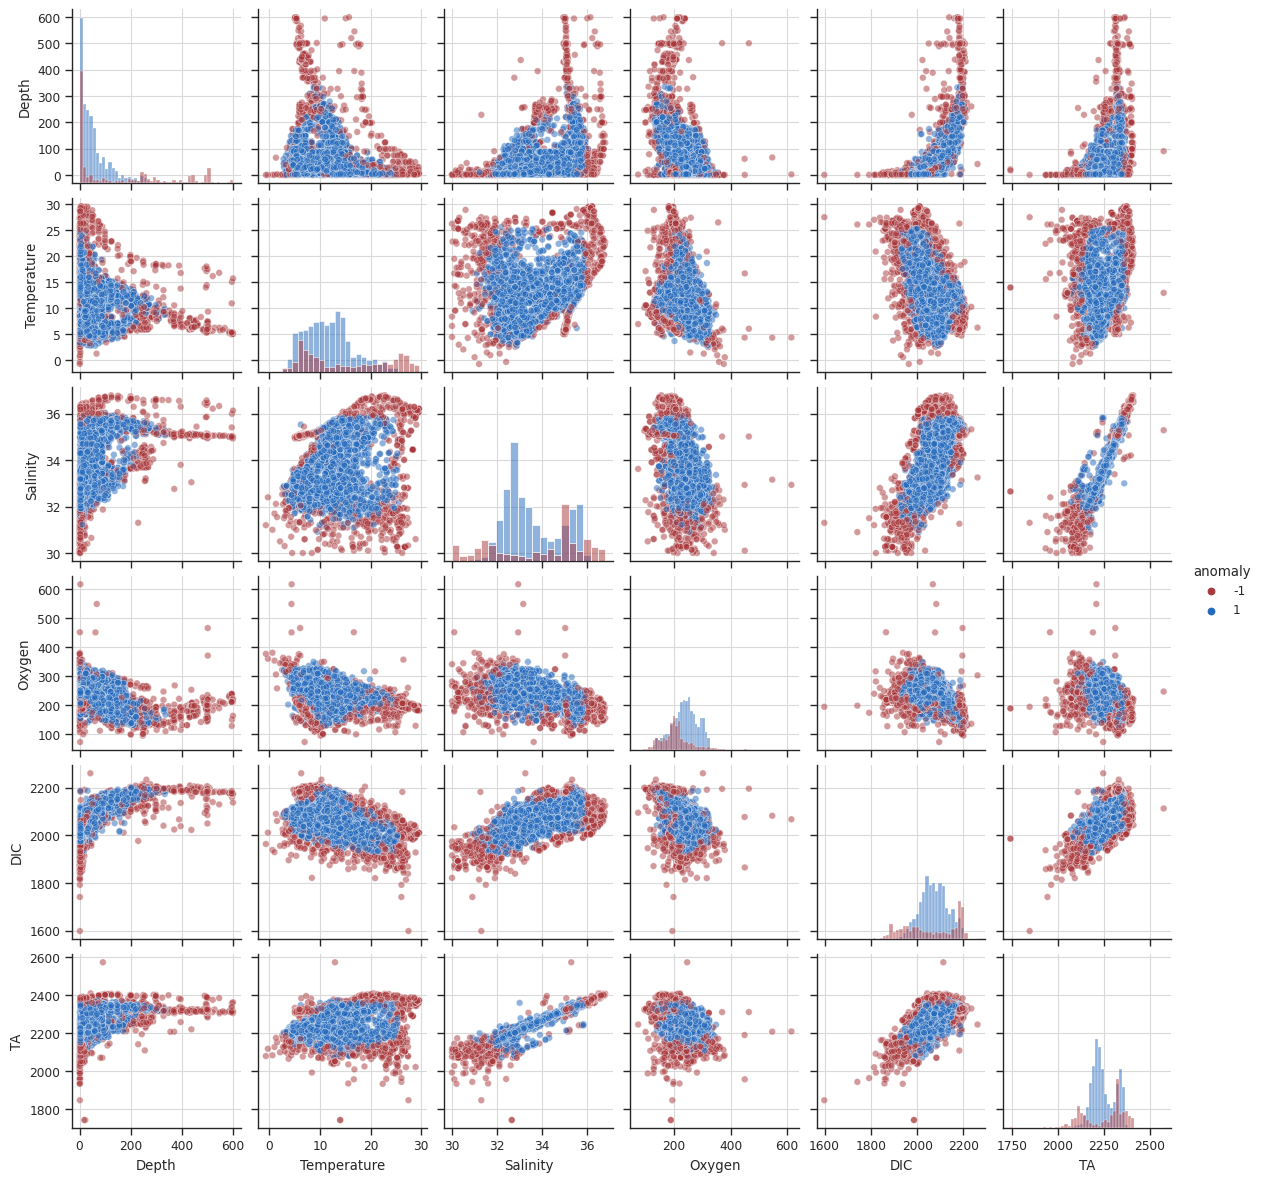

In [4]:
from sklearn.ensemble import IsolationForest

bot_vars = ['Depth', 'Temperature', 'Salinity', 'Oxygen', 'DIC', 'TA']

X = df[bot_vars].values
iforest = IsolationForest(n_estimators=500, random_state=42, contamination=0.3, n_jobs=-1).fit(X)
df['anom_score'] = iforest.score_samples(X)
df['anomaly'] = iforest.predict(X)

n_anom, n_pts = len(df[df.anomaly==-1]), len(df)
print('{} outliers out of {} data points ({:.1f}%)'.format(n_anom, n_pts, n_anom/n_pts*100))
print('Cleaned data set: {} points'.format(n_pts-n_anom))

fg = sns.pairplot(df, vars=bot_vars, hue='anomaly', palette='vlag_r', height=2, diag_kind='hist', plot_kws={'alpha':0.5})

## Feature importance

Estimate feature importance by fitting a Random Forest classifier to the Isolation Forest predictions.

Training score: 1.0000
Test score:     0.9540
Final model cross-validation mean score: 0.9362


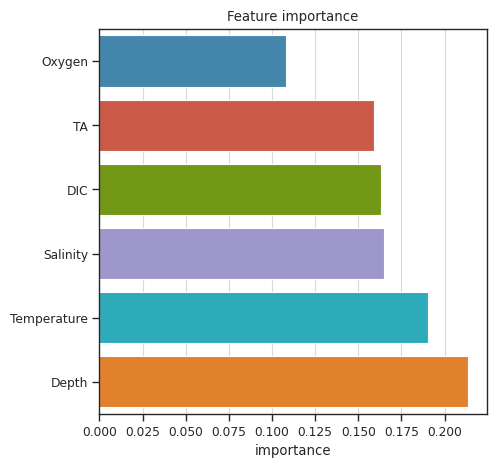

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

y = df['anomaly'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rfr = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
rfr.fit(X_train, y_train)
scores = cross_val_score(rfr, X, y, cv=5, n_jobs=-1)

print('Training score: {:.4f}'.format(rfr.score(X_train, y_train)))
print('Test score:     {:.4f}'.format(rfr.score(X_test, y_test)))
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

df_rfr = pd.DataFrame(rfr.feature_importances_, index=bot_vars, columns=['importance'])
df_rfr = df_rfr.sort_values('importance')
fig, ax = plt.subplots()
_ = sns.barplot(data=df_rfr, y=df_rfr.index, x='importance', orient='horizontal', ax=ax)
_ = ax.set_title('Feature importance')

## Data with outliers removed 

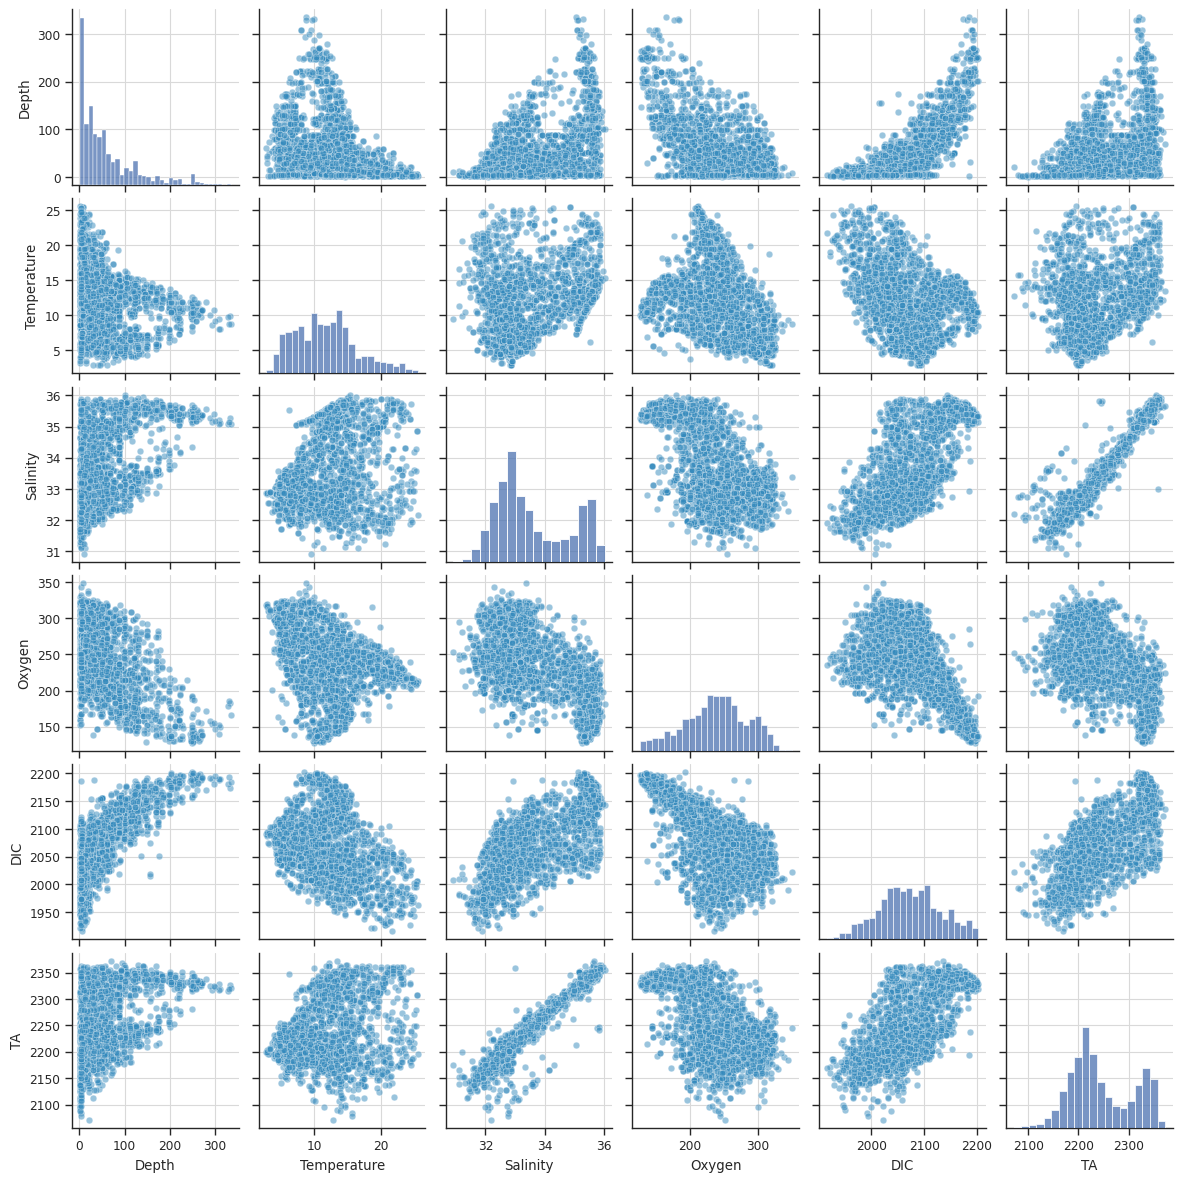

In [6]:
df_clean = df[df.anomaly==1]
fg = sns.pairplot(df_clean, vars=bot_vars, height=2, plot_kws={'alpha':0.5})